In [ ]:
## REPRESENTING THE CELLS IN 2D ##

In [2]:
#import packages

import community
import networkx as nx
import anndata
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
from sklearn.decomposition import TruncatedSVD
from scipy import sparse, io

matplotlib.rcParams.update({"font.size": 12})

In [2]:
# import data
adata = anndata.read("C:\\Users\\HP\\Downloads\\Kallisto_indiv\\SAMN23098196\\counts_unfiltered\\adata.h5ad")
adata

AnnData object with n_obs × n_vars = 261940 × 34859
    var: 'gene_name'

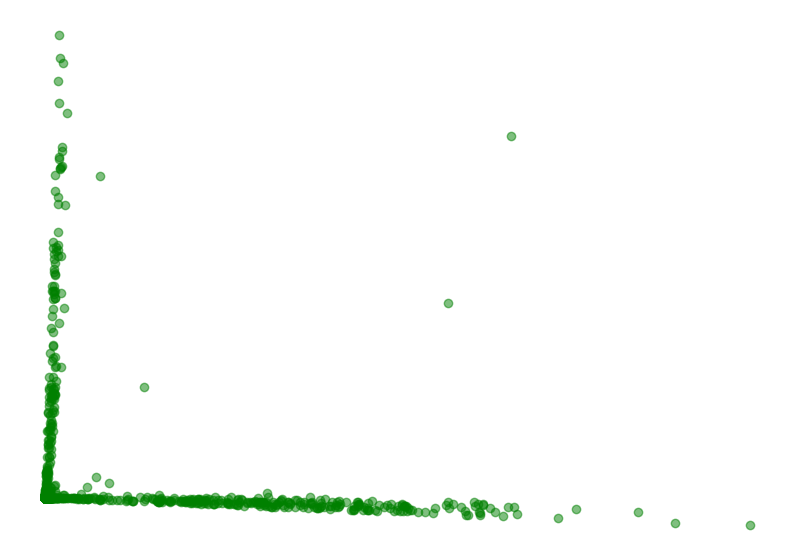

In [3]:
# Perform SVD
tsvd = TruncatedSVD(n_components=2)
tsvd.fit(adata.X)
X = tsvd.transform(adata.X)

# Plot the cells in the 2D PCA projection
fig, ax = plt.subplots(figsize=(10, 7))

ax.scatter(X[:,0], X[:,1], alpha=0.5, c="green")

plt.axis('off')
plt.show()

In [ ]:
## TEST FOR LIBRARY SATURATION ##
#For each cell we ask how many genes did we detect (or see non-zero expression). The idea is that if we have "saturated" our sequencing library then increasing the number of UMI counts (x-axis) will not yield an appreciable increase in the number of genes detected (y-axis).

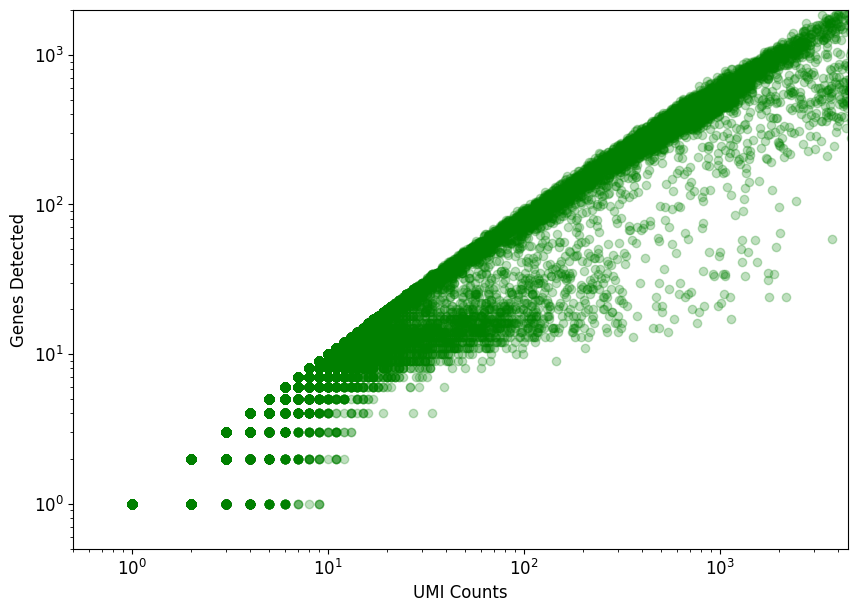

In [4]:
# Create a plot showing genes detected as a function of UMI counts.
fig, ax = plt.subplots(figsize=(10, 7))

x = np.asarray(adata.X.sum(axis=1))[:,0]
y = np.asarray(np.sum(adata.X>0, axis=1))[:,0]

ax.scatter(x, y, color="green", alpha=0.25)
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim((0.5, 4500))
ax.set_ylim((0.5,2000))


plt.show()

In [ ]:
## EXAMINE THE KNEE PLOT ##

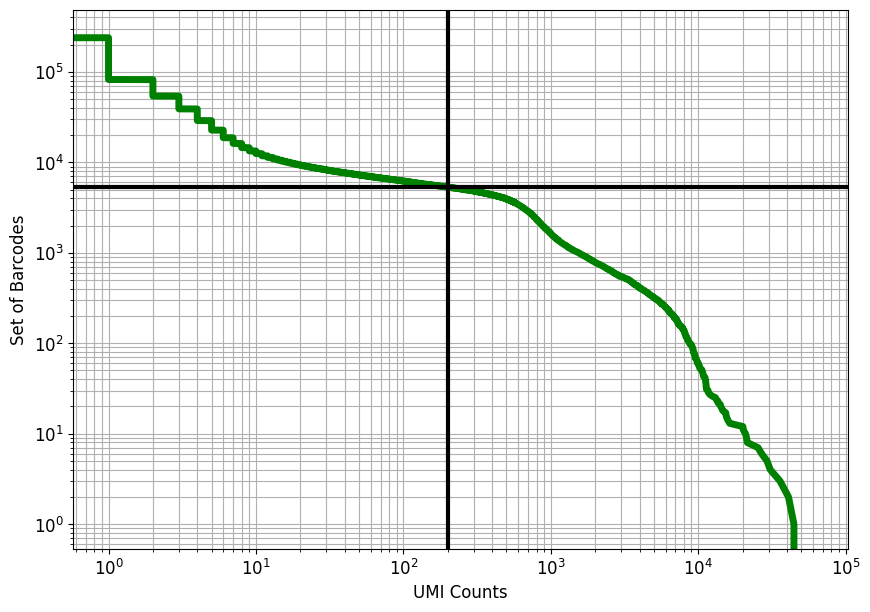

In [5]:
#@title Threshold cells according to knee plot { run: "auto", vertical-output: true }
cutoff =  200 #@param {type:"integer"}
knee = np.sort((np.array(adata.X.sum(axis=1))).flatten())[::-1]
cell_set = np.arange(len(knee))
num_cells = cell_set[knee > cutoff][::-1][0]

fig, ax = plt.subplots(figsize=(10, 7))


ax.loglog(knee, cell_set, linewidth=5, color="g")
ax.axvline(x=cutoff, linewidth=3, color="k")


ax.axhline(y=num_cells, linewidth=3, color="k")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")

plt.grid(True, which="both")
plt.show()

In [6]:
print(f"{num_cells:,.0f} cells passed the {cutoff} UMI threshold")

#the knee plot can be used to threshold cells based on the number of UMI counts they contain. The threshold is applied at the "knee", where there is a sharp dropoff in the number of UMIs per cell.

5,333 cells passed the 200 UMI threshold


In [ ]:
## FILTER EMPTY DROPLETS ##

In [7]:
adata

AnnData object with n_obs × n_vars = 261940 × 34859
    var: 'gene_name'

In [8]:
#filter the cells according to the threshold determined from the knee plot

expected_num_cells = 6611
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_cells(adata, min_counts=knee[expected_num_cells])

In [9]:
adata

AnnData object with n_obs × n_vars = 4673 × 34859
    obs: 'n_genes', 'n_counts'
    var: 'gene_name'

In [ ]:
## FILTER OUT GENES THAT ARE NOT PRESENT IN ANY CELLS ##

In [10]:
sc.pp.filter_genes(adata, min_cells=3)

In [11]:
adata

AnnData object with n_obs × n_vars = 4673 × 15946
    obs: 'n_genes', 'n_counts'
    var: 'gene_name', 'n_cells'

In [ ]:
## VISUALISING COUNT DISTRIBUTIONS ##

#examination of the gene count and UMI count distributions is useful QC to evaluate the quality of the library and how deeply it was sequenced.

C:\Python Software\Python3_11_3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


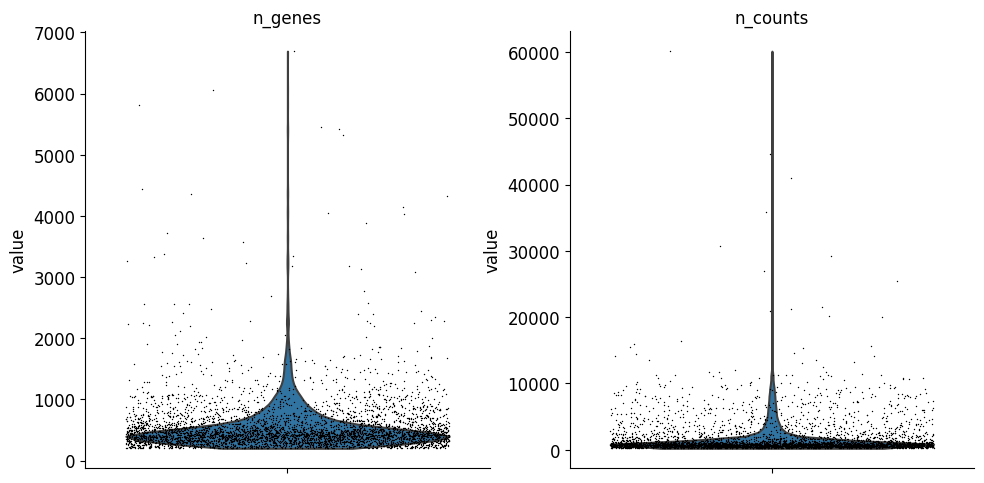

In [12]:
sc.pl.violin(adata, ['n_genes', 'n_counts'], jitter=0.4, multi_panel=True)

In [ ]:
## NORMALISE THE COUNTS ##

In [13]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

In [ ]:
## IDENTIFY HIGHLY VARIABLE GENES ##

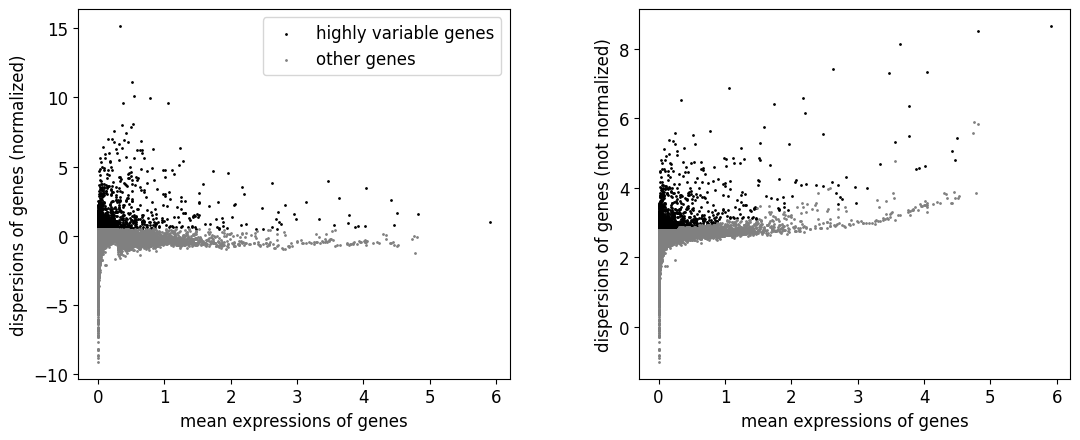

In [14]:
#flavor="cell_ranger" is consistent with Seurat and flavor="suerat" is not consistent with Seurat
sc.pp.highly_variable_genes(adata, min_mean=0.01, max_mean=8, min_disp=1, n_top_genes=3000, n_bins=20, flavor="seurat")
sc.pl.highly_variable_genes(adata)

In [15]:
sc.pp.scale(adata, max_value=10)

In [ ]:
## CLUSTERING AND VISUALISATION ##

In [3]:
sc.tl.louvain(adata)

NameError: name 'adata' is not defined

In [16]:
#cluster the cells using Louvain clustering
sc.tl.pca(adata, svd_solver='arpack', use_highly_variable=True, n_comps=10)
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=10, knn=True)
sc.tl.louvain(adata)

C:\Python Software\Python3_11_3\Lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Python Software\Python3_11_3\Lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Python Software\Python3_11_3\Lib\site-packages\umap\distances.py:1086: NumbaDeprecationWarning:

C:\Python Software\Python3_11_3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


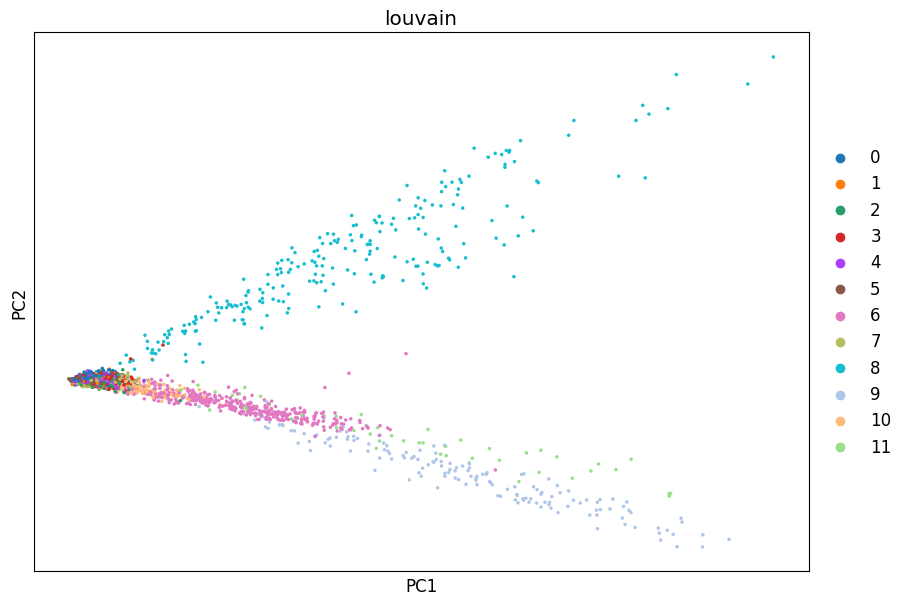

In [17]:
#perform PCA and plot the projection to the first two dimensions, with points colored according to the Louvain clusters.
fig, ax = plt.subplots(figsize=(10, 7))
sc.pl.pca(adata, color='louvain', ax=ax)

#the PCA representation is the result a linear map of the data from its ambient dimension, to low dimension (in the case above 2D). While such projections are useful, there are non-linear methods that can capture non-linear geometry in the data.

In [ ]:
## t-SNE ##

In [18]:
#visualize cells with t-SNE. The n_pcs parameter sets the number of principal components to project to prior to 
#performing t-SNE
sc.tl.tsne(adata, n_pcs=10)

C:\Python Software\Python3_11_3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


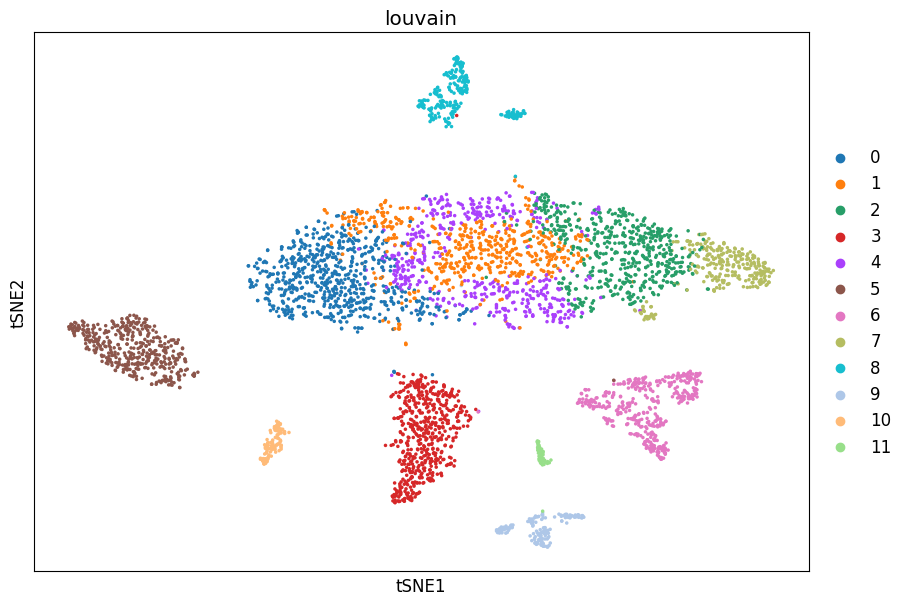

In [19]:
fig, ax = plt.subplots(figsize=(10, 7))
sc.pl.tsne(adata, color='louvain', ax=ax)

In [ ]:
## UMAP ##

In [20]:
#visualize cells with t-SNE. The n_pcs parameter sets the number of principal components to project to prior to 
#performing t-SNE
sc.tl.umap(adata)

C:\Python Software\Python3_11_3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


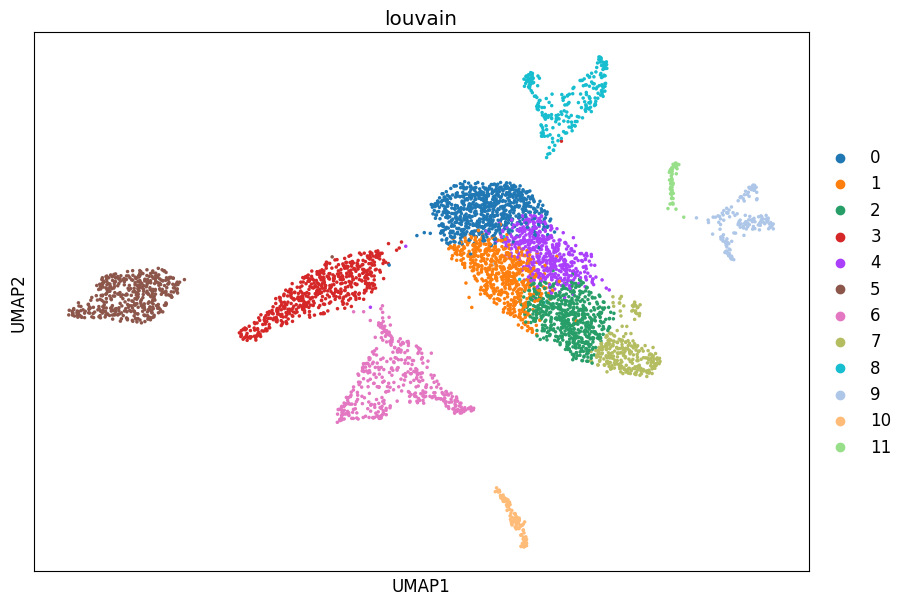

In [21]:
fig, ax = plt.subplots(figsize=(10, 7))
sc.pl.umap(adata, color='louvain', ax=ax)

C:\Python Software\Python3_11_3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


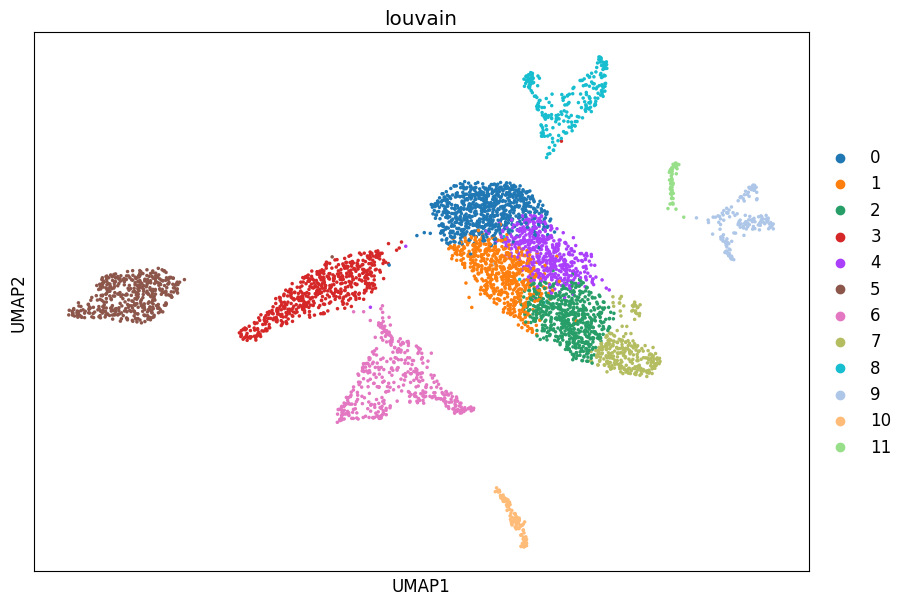

In [22]:
#visualize cells with UMAP.
sc.tl.umap(adata, 
min_dist=0.5, 
spread=1.0, 
n_components=2, 
maxiter=None, 
alpha=1.0, 
gamma=1.0, 
negative_sample_rate=5, 
init_pos='spectral', 
random_state=0, 
a=None, 
b=None, 
copy=False, 
method='umap')
fig, ax = plt.subplots(figsize=(10, 7))
sc.pl.umap(adata, color='louvain', ax=ax)